In [34]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score


from itertools import chain, combinations

sns.set()

In [35]:
# importing and pre-processing

# import data
res = pd.read_csv(
    "data/NEallResults.csv"
)

# split data into data and metadata
res = res.drop(labels=["Group", "Regions"], axis=1) # drop unused data
metadata = res.iloc[:, :4] # select data not used for clustering
data = res.iloc[:, 4:] # select data for clustering

# impute data
data_np = data.to_numpy() # convert to numpy for imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data_np = imp_mean.fit_transform(data_np) # make and fit imputer

#scale data
scaler = preprocessing.MinMaxScaler()
resnorm = pd.DataFrame(scaler.fit_transform(data_np))
resnorm = pd.concat([metadata, resnorm], axis=1)
resnorm.columns = res.columns

# subset to known
known = resnorm[resnorm["Status"].notnull()]

In [36]:
# split known to data and classification target
known_meta = known.iloc[:, :4]
x = known.iloc[:, 5:]  # data for prediction
y = known["Status"]  # classification targets

In [37]:
# get information from various tests of feature importance

feature_importance = pd.DataFrame(columns=["feature", "f val", "f val p-val", "mi"])

feature_importance["feature"] = x.columns

f_class_results = f_classif(x, y)
mi_results = mutual_info_classif(x, y, discrete_features=False)

feature_importance["f val"] = f_class_results[0]
feature_importance["f val p-val"] = f_class_results[1]
feature_importance["mi"] = mi_results


feature_importance



,feature,f val,f val p-val,mi
0,MLsimilarity,0.887026,0.349391,0.000000
1,AAdistance,7.125996,0.009358,0.091326
2,AAsimilarity,5.985981,0.016828,0.029731
3,ZtestDistance,0.092531,0.761849,0.000000
4,ZtestSimilarity,0.215602,0.643793,0.000000
5,Nsdistance,7.220852,0.008919,0.083723
6,Nssimilarity,5.883221,0.017759,0.037547
7,PatristicDistance,5.056820,0.027547,0.080460
8,PatristicSimilarity,0.417659,0.520134,0.014432


In [38]:
# select features by mutual information 

selector = SelectPercentile(mutual_info_classif, percentile=50).fit(x, y)  # create selector
cols = x.columns[selector.get_support(indices=True)]  # get colnames
mi_best_known = selector.transform(x)  # transform to selected features
mi_best_known = pd.DataFrame(mi_best_known)  # convert to df
mi_best_known.columns = cols  # re-add colnames

mi_best_known.head()

,AAdistance,AAsimilarity,Nsdistance,PatristicDistance
0,0.024540,0.293343,0.015811,0.100611
1,0.150733,0.000000,0.135177,0.214386
2,0.487836,0.000000,0.412567,0.313117
3,0.338045,0.000000,0.321436,0.393512
4,0.036894,0.042640,0.023351,0.026798


In [39]:
# select features by f value

selector = SelectPercentile(f_classif, percentile=50).fit(x, y)  # create selector
cols = x.columns[selector.get_support(indices=True)]  # get colnames
f_best_known = selector.transform(x)  # transform to selected features
f_best_known = pd.DataFrame(f_best_known)  # convert to df
f_best_known.columns = cols  # re-add colnames

f_best_known.head()

,AAdistance,AAsimilarity,Nsdistance,Nssimilarity
0,0.024540,0.293343,0.015811,0.302313
1,0.150733,0.000000,0.135177,0.000000
2,0.487836,0.000000,0.412567,0.000000
3,0.338045,0.000000,0.321436,0.000000
4,0.036894,0.042640,0.023351,0.043098


In [40]:
def create_kmeans(x, k, weights=None):
    """Create list of cluster ID's using k-means clustering.

    Args:
        x (ndarray): Data to cluster.
        k (int): number of clusters to make

    Returns:
        array: cluster ID's

    """
    # kmeans = make_pipeline(
    #     StandardScaler().fit_transform(),
    #     KMeans(n_clusters=k)
    # )
    kmeans = KMeans(n_clusters=k)

    return kmeans.fit_predict(x, sample_weight=weights)

In [41]:
# out of curiosity, testing these selections with kmeans

def kmeans_graph(df, name, weights=None):
    test = df
    # print(test.iloc[:, 4:].head())
    test.loc[:, "Cluster"] = create_kmeans(test.iloc[:, 4:], 2, weights)

    nmatch1 = test[(test["Status"] == "native") & (test["Cluster"] == 1)].shape[0]
    nmatch0 = test[(test["Status"] == "native") & (test["Cluster"] == 0)].shape[0]
    imatch1 = test[(test["Status"] == "introduced") & (test["Cluster"] == 1)].shape[0]
    imatch0 = test[(test["Status"] == "introduced") & (test["Cluster"] == 0)].shape[0]

    nmatch_choice = 1 if nmatch1 > nmatch0 else 0
    test.loc[:, "Predict"] = ["native" if x == nmatch_choice else "introduced" for x in test["Cluster"]]
    test.loc[:, "Correct"] = test.apply(lambda row: 1 if row["Status"] == row["Predict"] else 0, axis=1)
    
    
    acc = 100 * test["Correct"].sum() / test["Correct"].shape[0]
    nerr = test[(test["Status"] == "native") & (test["Correct"] == 0)].shape[0] / test[test["Status"] == "native"].shape[0] * 100
    ierr = test[(test["Status"] == "introduced") & (test["Correct"] == 0)].shape[0] / test[test["Status"] == "introduced"].shape[0] * 100

    print("Balanced accuracy score:                   {:.2f}".format(metrics.balanced_accuracy_score(test["Status"], test["Predict"])))
    print("Percent of Predictions correct:            {:.2f}%".format(acc))
    print("Percent of Native mislabled to Introduced: {:.2f}%".format(nerr))
    print("Percent of Introduced mislabled to Native: {:.2f}%".format(ierr))

    out = sns.pairplot(
    data=df,
    vars=df.columns[4:-3],
    hue="Predict"
    )
    out.savefig("plots/{}.png".format(name))

In [42]:
# fix resulting index issues for mi test

known_meta = known_meta.reset_index(drop=True)
mi_best_known = mi_best_known.reset_index(drop=True)
mi_test_sheet = pd.concat([known_meta, mi_best_known], axis=1)

Balanced accuracy score:                   0.62
Percent of Predictions correct:            72.00%
Percent of Native mislabled to Introduced: 25.37%
Percent of Introduced mislabled to Native: 50.00%


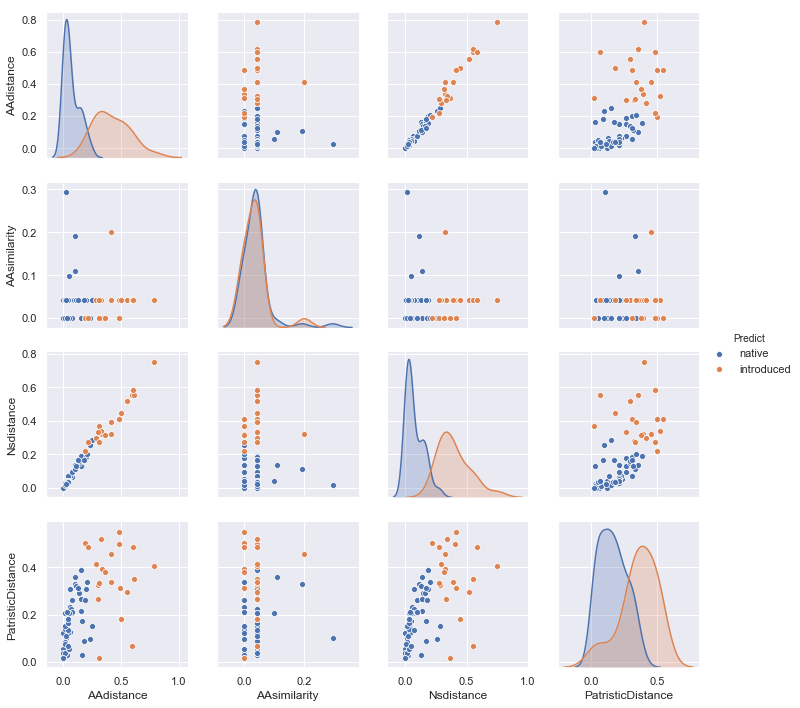

In [43]:
kmeans_graph(mi_test_sheet, "md_cluster_mi_sel_weighted", weights=1/known_meta["N"])

In [44]:
# fix resulting index issues for f test

known_meta = known_meta.reset_index(drop=True)
f_best_known = f_best_known.reset_index(drop=True)
f_test_sheet = pd.concat([known_meta, f_best_known], axis=1)

Balanced accuracy score:                   0.63
Percent of Predictions correct:            73.33%
Percent of Native mislabled to Introduced: 23.88%
Percent of Introduced mislabled to Native: 50.00%


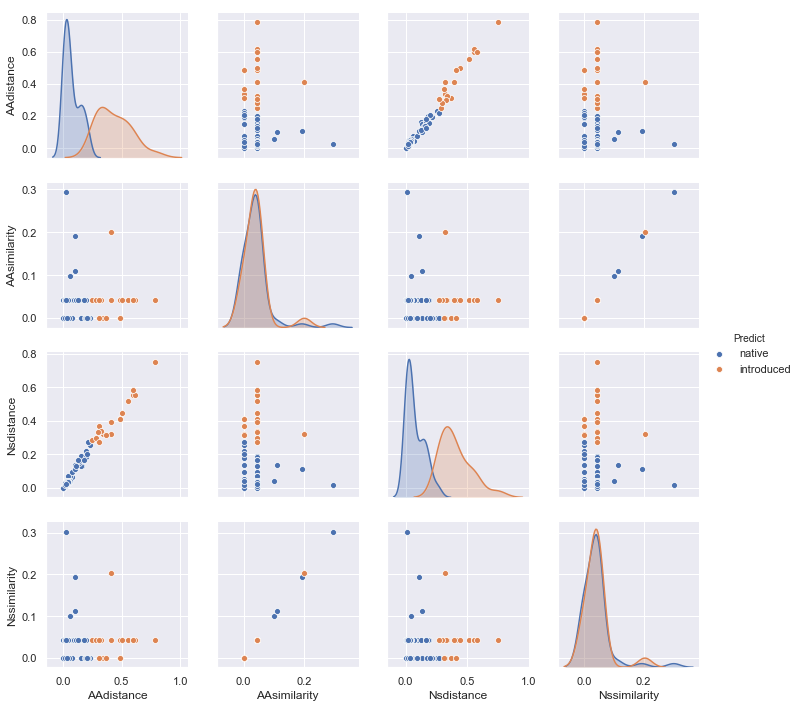

In [45]:
kmeans_graph(f_test_sheet, "md_cluster_f_sel_weighted", weights=1/known_meta["N"])


In [46]:
# split data into test and train data

x = f_best_known
y = known_meta["Status"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle=True, stratify=y)

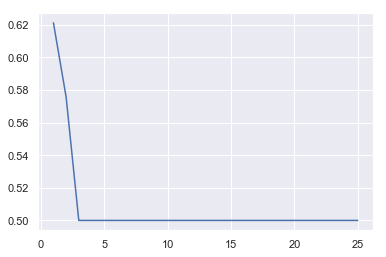

In [47]:
# test knn for optimal k value

scores = []
nerr = []
ierr = []


for k in range(1, 26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.balanced_accuracy_score(y_test, y_pred))
    res = pd.DataFrame(columns=["Status", "pred", "Correct"])
    res["Status"] = y_test
    res["pred"] = y_pred
    res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

    nerr.append(res[(res["Status"] == "native") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "native"].shape[0] * 100)
    ierr.append(res[(res["Status"] == "introduced") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "introduced"].shape[0] * 100)





sns.lineplot(
    x=list(range(1, 26)),
    y=scores
)

    

In [48]:
# take a look at some other measures

results = pd.DataFrame(columns=["k", "acc", "nerr", "ierr"])
results["k"] = list(range(1, 26))
results["acc"] = scores
results["nerr"] = nerr
results["ierr"] = ierr

results

,k,acc,nerr,ierr
0,1,0.621212,9.090909,66.666667
1,2,0.575758,18.181818,66.666667
2,3,0.500000,0.000000,100.000000
3,4,0.500000,0.000000,100.000000
4,5,0.500000,0.000000,100.000000
5,6,0.500000,0.000000,100.000000
6,7,0.500000,0.000000,100.000000
7,8,0.500000,0.000000,100.000000
8,9,0.500000,0.000000,100.000000
9,10,0.500000,0.000000,100.000000


0.5757575757575758
k        2.000000
acc      0.575758
nerr    18.181818
ierr    66.666667
Name: 1, dtype: float64


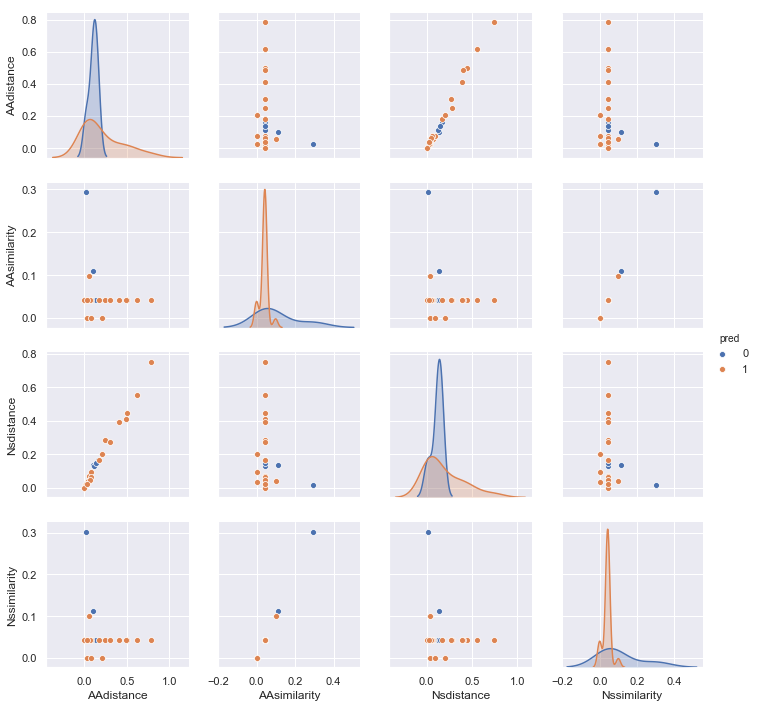

In [49]:
# plot the outcome of the best k



knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

res = pd.DataFrame(columns=["Status", "pred", "Correct"])
res["Status"] = [1 if y == "native" else 0 for y in y_test]
res["pred"] = [1 if y == "native" else 0 for y in y_pred]
res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

res.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
res = pd.concat([x_test, res], axis=1)

print(metrics.balanced_accuracy_score(y_test, y_pred))
print(results.iloc[1])

sns.pairplot(
    data=res,
    vars=res.columns[:4],
    hue="pred"
)



,k,acc,nerr,ierr
0,1,0.810606,4.545455,33.333333
1,2,0.810606,4.545455,33.333333
2,3,0.500000,0.000000,100.000000
3,4,0.500000,0.000000,100.000000
4,5,0.500000,0.000000,100.000000
5,6,0.500000,0.000000,100.000000
6,7,0.500000,0.000000,100.000000
7,8,0.500000,0.000000,100.000000
8,9,0.500000,0.000000,100.000000
9,10,0.500000,0.000000,100.000000


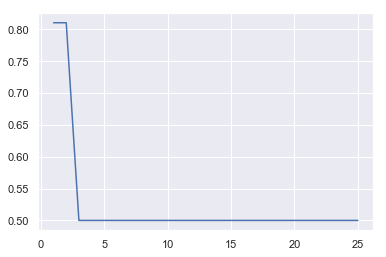

In [50]:
# try everything again but for mi

# split data into test and train data

x = mi_best_known
y = known_meta["Status"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33)
# test knn for optimal k value

scores = []
nerr = []
ierr = []

for k in range(1, 26):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.balanced_accuracy_score(y_test, y_pred))
    
    res = pd.DataFrame(columns=["Status", "pred", "Correct"])
    res["Status"] = y_test
    res["pred"] = y_pred
    res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

    nerr.append(res[(res["Status"] == "native") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "native"].shape[0] * 100)
    ierr.append(res[(res["Status"] == "introduced") & (res["Correct"] == 0)].shape[0] / res[res["Status"] == "introduced"].shape[0] * 100)


sns.lineplot(
    x=list(range(1, 26)),
    y=scores
)

# take a look at some other measures

results = pd.DataFrame(columns=["k", "acc", "nerr", "ierr"])
results["k"] = list(range(1, 26))
results["acc"] = scores
results["nerr"] = nerr
results["ierr"] = ierr

results

let's redo the test for f values with more rigourous methods

In [51]:
# a helper function for getting an mean balanced accuracy

def xeval(classifier, x, y, folds):
    """Cross-validate a classifier.

    Args:
        classifier (varies): A classifier
        x (ndarray): Test data.
        y (series): Class values.
        folds (int): Number of folds to use.

    Returns:
        float: Mean accuracy.

    """
    return cross_val_score(classifier, x, y, cv=folds, scoring="balanced_accuracy").mean()

[0.7666666666666666, 0.7833333333333333, 0.7666666666666666, 0.7666666666666666, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]


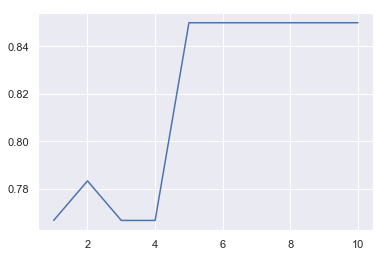

In [52]:
scores = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    scores.append(xeval(knn, x_test, y_test, folds=10))

print(scores)
    
sns.lineplot(
    x=list(range(1, 11)),
    y=scores
)

In [53]:
# plot the outcome of the best k



knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

res = pd.DataFrame(columns=["Status", "pred", "Correct"])
res["Status"] = [1 if y == "native" else 0 for y in y_test]
res["pred"] = [1 if y == "native" else 0 for y in y_pred]
res["Correct"] = res.apply(lambda row: 1 if row["Status"] == row["pred"] else 0, axis=1)

res.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
res = pd.concat([x_test, res], axis=1)

print(metrics.balanced_accuracy_score(y_test, y_pred))

print(res)

sns.pairplot(
    data=res,
    vars=res.columns[:4],
    hue="pred",
)

0.8106060606060606
    AAdistance  AAsimilarity  Nsdistance  PatristicDistance  Status  pred  \
0     0.036894      0.042640    0.023351           0.026798       1     1   
1     0.783682      0.042640    0.749235           0.404795       0     0   
2     0.045209      0.042640    0.043099           0.170663       1     1   
3     0.150733      0.000000    0.135177           0.214386       0     1   
4     0.057525      0.042640    0.069069           0.308886       1     1   
5     0.196765      0.042640    0.185473           0.308886       1     1   
6     0.000000      0.042640    0.000000           0.055007       1     1   
7     0.012242      0.042640    0.015532           0.083216       1     1   
8     0.485636      0.000000    0.411711           0.550541       1     1   
9     0.324222      0.042640    0.337553           0.520451       1     1   
10    0.012355      0.042640    0.007850           0.074753       1     1   
11    0.038487      0.042640    0.032276           0.1650

Conclusion: knn has some strange potential for high balanced accuracy (was unable to reproduce the effect), but would appear to perform poorly on average.

Additionally, feature selection would appear to perform adequately, but it still might be worthwhile to brute-force select on training data. This has potential for over-fitting, however. Further testing on the next dataset is necessary.